In [3]:
#!pip install CommonRegex
!pip install pgeocode

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pytesseract 
from PIL import Image, ImageOps
import re
from commonregex import CommonRegex
import pgeocode

texts_df = pd.read_csv('texts.csv')


In [9]:
print(texts_df['0'][0])

    
  
  
  

GREEN FIELD
5305 E PACIFIC COAST HWY
Long Beach, CA 90804
(S62) 597-0906

Server: Francis Station: 4
Order #: 69923 Dine In
Table: B11 Guests: 2
1 Coffee 3.00
2 Lunch 45.90
1 Coke 3.00
SUB TOTAL: 51.90
Tax 1:

TOTAL: $56.58

5/26/2016 12:53:10 PM

INAH

THANK YOU!

 



In [10]:
#Change this function to extract ITEMS (with their respective prices)
"""After geting the prices, locate their boxes, search for boxes that have similar height, assume those are 
the names of the items. Then look for the largest box (or the box on top), assume those are the names of the shops). """

def extract_prices(text):
    prices = CommonRegex(text).prices
    if len(prices) > 1:
        return prices
    else:
        return np.nan
    
    
    return CommonRegex(text).prices

In [11]:
def extract_geo(text):
    #zip_code 
    us_zip = r'(\d{5}\-?\d{0,4})'
    zip_code = re.search(us_zip, text)
    try:
        zip_code = zip_code[0]
        nomi = pgeocode.Nominatim('us')
        geodata = nomi.query_postal_code(zip_code)
        longitude = geodata['longitude']
        latitude = geodata['latitude']
    except:
        zip_code = np.nan
        longitude = np.nan
        latitude = np.nan
        
    
    address = CommonRegex(text).street_addresses
    if len(address) == 1:
        address =  address[0]
    else:
        address = np.nan

        
    return zip_code, longitude, latitude, address
    
    

In [12]:
def extract_time(text):
    times = CommonRegex(text).times
    if len(times) == 1:
        return times[0]
    else:
        return np.nan

In [13]:
#texts_df = pd.read_csv('texts.csv')
geos = []
times = []
for text in texts_df['0']:
    times.append(extract_time(text))
    geos.append(extract_geo(text))



In [14]:
df = pd.DataFrame(data = geos, columns = ['Zipcode','Latitude', 'Longitude', 'Address' ])
df['Time'] = times

In [15]:
prices = []
for text in texts_df['0']:
    prices.append(extract_prices(text))
df['prices'] = prices


database = df.explode('prices')
database.reset_index(inplace = True)

In [16]:
database.head()

,index,Zipcode,Latitude,Longitude,Address,Time,prices
0,0,90804,-118.1357,33.7857,5305 E PACIFIC COAST HWY,12:53,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2,378752,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN
4,4,90280,-118.2013,33.9462,8510 GARFIELD AVE.,11:19 AM,$8.39


<AxesSubplot:>

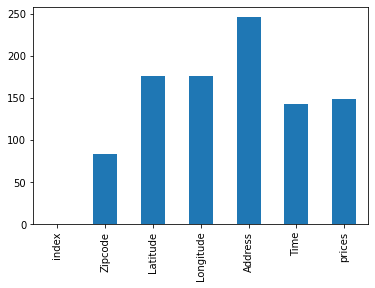

In [17]:
database.isna().sum().plot(kind = 'bar')

<AxesSubplot:>

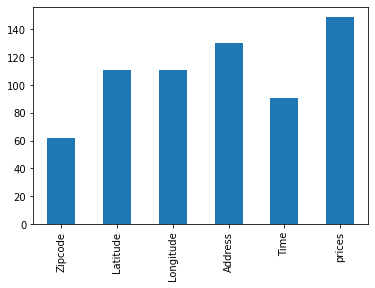

In [18]:
df.isna().sum().plot(kind = 'bar')

In [19]:
def extract_text(url):
    import pytesseract 
    from PIL import Image
    
    """extracts test out of image
    --inputs= image_url """
    #opening the image
    im=Image.open(url)
    grey= im.convert(mode="L")
    #threshold= 160
    #image=grey.point(lambda x: 255 if x > threshold else 0)
    
    #configuration for pytesseract to operate with text extraction
    config = ('-l eng --oem 1 --psm 3')
    text = pytesseract.image_to_string(grey, config=config)
    
    return text

In [22]:
import pytesseract 
from PIL import Image

"""extracts test out of image
--inputs= image_url """

url=(r"images/large-receipt-image-dataset-SRD/1000-receipt.jpg")

#opening the image
#pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
im=Image.open(url)
grey= im.convert(mode="L")
#threshold= 160
#image=grey.point(lambda x: 255 if x > threshold else 0)

#configuration for pytesseract to operate with text extraction

config = ('-l eng --oem 1 --psm 3')
text = pytesseract.image_to_string(grey, config=config)

boxes = pytesseract.image_to_data(im,output_type=pytesseract.Output.DATAFRAME)



TesseractNotFoundError: C:\Program Files\Tesseract-OCR\tesseract.exe is not installed or it's not in your PATH. See README file for more information.

In [ ]:
boxes[boxes['text'] == '3.00']

In [42]:
boxes[boxes['text'] == 'Coffee']

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
52,5,1,4,1,3,2,192,539,68,19,88.761948,Coffee


In [45]:
boxes.block_num.value_counts()

4    33
2    19
1    10
3     7
6     6
5     5
8     5
7     4
0     1
Name: block_num, dtype: int64

In [3]:
help (functions)

Help on module functions:

NAME
    functions

FUNCTIONS
    extract_data(text)
    
    extract_text(url)

DATA
    url = 'ss'

FILE
    c:\users\consultant\documents\github\scotia-bank-reciept-processing-and-budget-forcasting\functions.py




In [1]:
import functions 

In [2]:
text=functions.extract_text(r"images/large-receipt-image-dataset-SRD/1011-receipt.jpg")

AttributeError: 'NoneType' object has no attribute 'reshape'

In [3]:
data=functions.extract_data(text)
data

,Zipcode,Latitude,Longitude,Address,prices,time
0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
import numpy as np
def contour_to_rect(contour):
    
    pts = contour.reshape(4,2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))


def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [10]:
def extract_text(url):
    import pytesseract 
    from PIL import Image
    import numpy as np
    import cv2
    """extracts test out of image
    --inputs= image_url """
    #opening the image
    

    frame=cv2.imread(url)
    #grey= im.convert(mode="L")
    resize_ratio = 500 / frame.shape[0]
    
    original = frame.copy()
    
    image = opencv_resize(frame, resize_ratio)
    
    frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    d = pytesseract.image_to_data(frame, output_type=pytesseract.Output.DICT)
    n_boxes = len(d['level'])  
    for i in range(n_boxes):
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    

    
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    dilated = cv2.dilate(blurred, rectKernel)
    edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[0]
    
    image_with_largest_contours = cv2.drawContours(frame.copy(), largest_contours, -1, (0,255,0), 2)
    def approximate_contour(contour):
        peri = cv2.arcLength(contour, True)
        return cv2.approxPolyDP(contour, 0.032 * peri, True)
    
    def get_receipt_contour(contours):    
    # loop over the contours
        for c in contours:
            approx = approximate_contour(c)
            # if our approximated contour has four points, we can assume it is receipt's rectangle
            if len(approx) == 4:
                return approx
        
    receipt_contour = get_receipt_contour(largest_contours)
    print (receipt_contour)
    
    #image_with_receipt_contour = cv2.drawContours(frame.copy(), [receipt_contour], -1, (0, 255, 0), 2)
    scanned = wrap_perspective(origional.copy(), contour_to_rect(receipt_contour))
    

    
    
    config = ('-l eng --oem 1 --psm 3')
    text = pytesseract.image_to_string(image_with_largest_contours , config=config)
    
    return text


In [11]:
extract_text(r"images/large-receipt-image-dataset-SRD/1011-receipt.jpg")

NameError: name 'cv2' is not defined